In [80]:
from private.db.tianrun.spot.fdw.new_energy_actual_power import market_hourly_actual_power, market_name_dict
from private.db.tencnet.openmeteo.china_openmeteo_forecast3 import ProvinceForecastData

# from finance_utils.electrical2.spot.probabilistic.forecast.torch.transformer.vanilla2 import (
#     VanillaTransformer, vanilla_transformer_tester, vanilla_transformer_trainer, vanilla_transformer_trainer2)

from finance_utils.electrical2.spot.probabilistic.forecast.torch.transformer.vanilla3 import (
    VanillaTransformerEncoder, vanilla_transformer_tester, vanilla_transformer_trainer, vanilla_transformer_trainer2)

from private.db.tencnet.openmeteo.china_openmeteo_forecast3 import cma_new_energy_args, ecmwf_new_energy_args
from finance_utils.electrical2.spot.probabilistic.forecast.datasource.pfd_and_new_energy import torch_data_set as torch_data_set1
from finance_utils.electrical2.spot.probabilistic.forecast.datasource.pfd_and_new_energy2 import torch_data_set as torch_data_set2
from finance_utils.electrical2.spot.probabilistic.forecast.torch.normalization.basic import MinMax,ZScore,RobustScaler
import numpy
import pickle
from easy_datetime.timestamp import TimeStamp

import torch
from matplotlib import pyplot as plt
# from data_utils.serial_utils.series_trans_utils import MinMax, ZScore, RobustScaler, KmeansCluster

import os

import torch
from torch import nn

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor

In [21]:
root = r"E:\code\github\private\private\db\tencnet\openmeteo\data"

pfd = ProvinceForecastData("shanxi", "2024-10-1", "2024-10-31")
if os.path.exists(f"{root}\\china_ecmwf.pfd"):
    pass
else:
    pfd.add_new_energy_forecast("ecmwf")
    pfd.save(f"{root}\\china_ecmwf.pfd")


with open(f"{root}\\test_cma.pfd", "rb") as f:
    pfd:ProvinceForecastData = pickle.loads(f.read())
    
with open(f"{root}\\china_cma.pfd", "rb") as f:
    pfd2:ProvinceForecastData = pickle.loads(f.read())
    
with open(f"{root}\\china_ecmwf.pfd", "rb") as f:
    pfd3:ProvinceForecastData = pickle.loads(f.read())
    
print(pfd.stdt)
print(pfd.eddt)
# print(pfd.ecmwf_forecast_matrix[0])

2024-10-01 00:00:00
2024-10-31 23:59:59


In [35]:
x_norml_method = ZScore
y_norml_method = ZScore

fore_start = TimeStamp("2024-10-1")
fore_days = 10
fore_end = fore_start + ["day", fore_days]
x1,x_hat1,y1,y_hat1, yp1 = torch_data_set1(pfd, x_norml_method, y_norml_method, fore_start, fore_end, 
                                     ["cma", "evening", 1, 1],
                                     delete_column=[1], province_name="PHBSX",dims=cma_new_energy_args)

x2,x_hat2,y2,y_hat2, yp2 = torch_data_set2(pfd, x_norml_method, y_norml_method, fore_start, fore_end, 
                                     ["cma", "evening", 1, 1],
                                     delete_column=[1], province_name="PHBSX",dims=cma_new_energy_args)

# x2b,x_hat2b,_,_, _ = torch_data_set2(pfd2, x_norml_method, y_norml_method, fore_start, fore_end, 
#                                      ["cma", "evening", 1, 1],
#                                      delete_column=[0, 1], province_name="PHBSX",dims=cma_new_energy_args)

x2b,x_hat2b,_,_, _ = torch_data_set2(pfd2, x_norml_method, y_norml_method, fore_start, fore_end, 
                                     ["cma", "evening", 1, 1],
                                     delete_column=[0, 1], province_name="PHBSX",dims=cma_new_energy_args)

# x,x_hat,y,y_hat,yp = x2,x_hat2,y2,y_hat2, yp2


100%|██████████| 4507/4507 [00:00<00:00, 187620.74it/s]


In [42]:
x = torch.column_stack((x2, x2b))
x_hat = torch.column_stack((x_hat2, x_hat2b))
# 
# x = x2
# x_hat = x_hat2

y,y_hat, yp = y2,y_hat2, yp2

print(x2.shape)
print(x2b.shape)
print(x.shape)
print(y.shape)
print(x_hat.shape)
print(y_hat.shape)
print(yp.shape)
print(fore_start)
print(fore_end)

torch.Size([240, 1131])
torch.Size([240, 4505])
torch.Size([240, 5636])
torch.Size([240])
torch.Size([264, 5636])
torch.Size([264])
(4,)
2024-10-01 00:00:00
2024-10-11 00:00:00


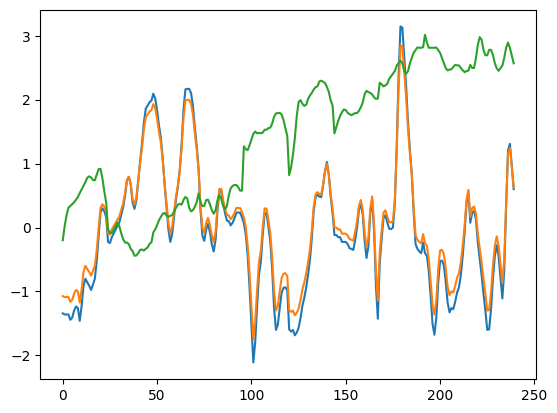

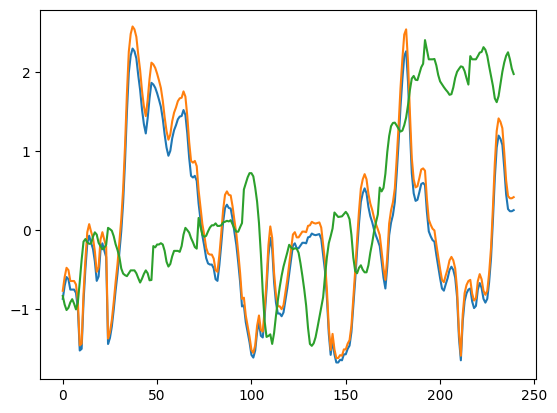

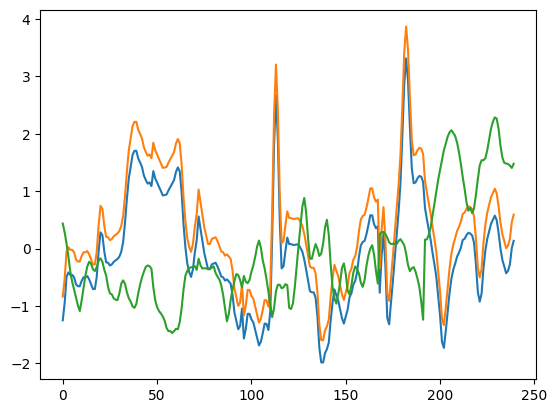

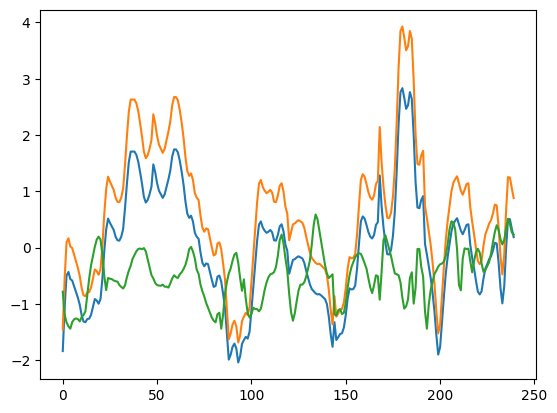

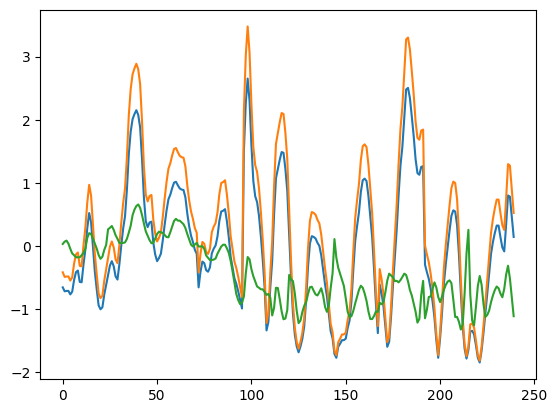

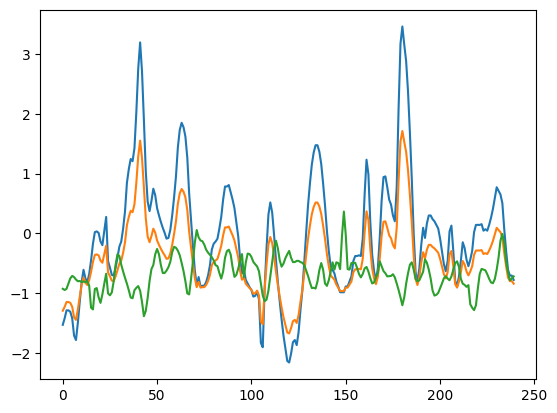

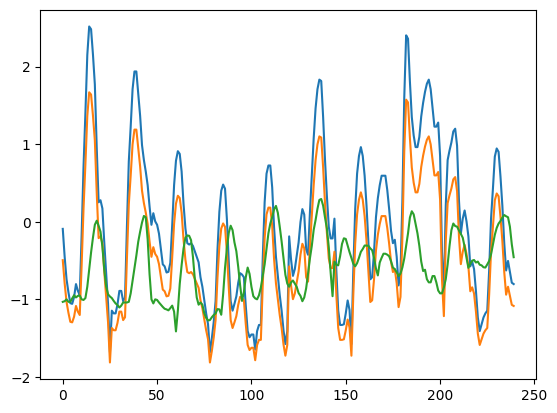

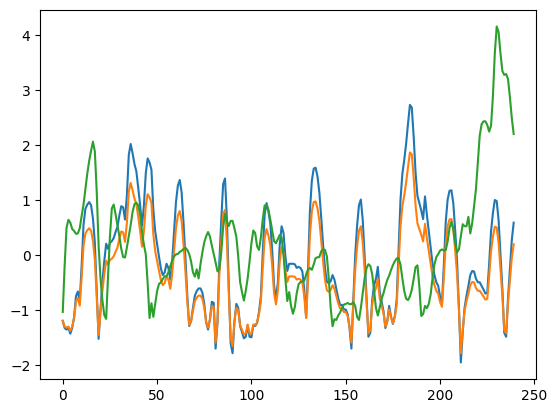

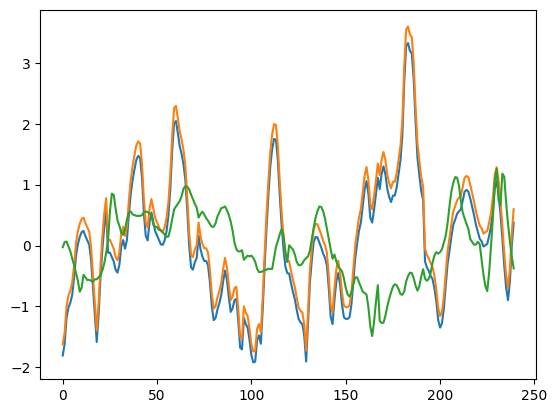

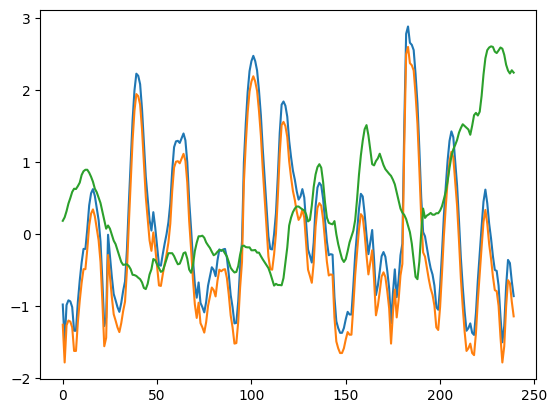

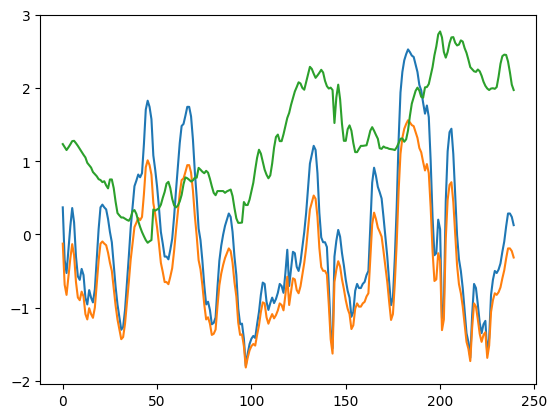

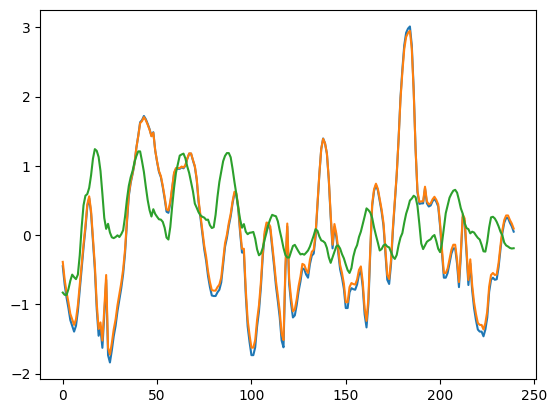

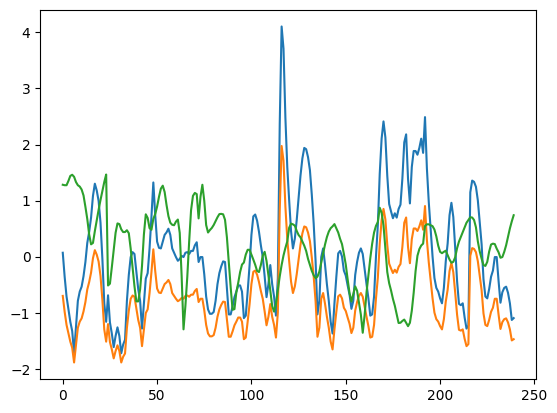

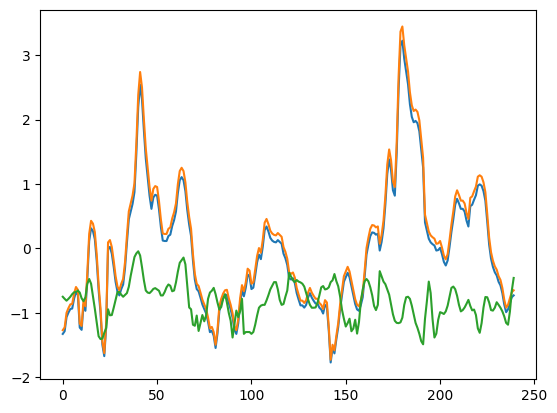

In [43]:
# plt.plot(x1[0])
# plt.plot(x2[0])
# plt.plot(x2b[0])
# plt.show()
for i in range(6, 20):
    plt.plot(x1[:,i])
    plt.plot(x2[:,i])
    plt.plot(x2b[:,i-1])
    plt.show()

In [81]:
input_size = x.shape[1]
d_model = 256
dim_feedforward = 1024
nhead = 4
output_size = 1
num_layers = 2
batch_size = fore_days * 4
# batch_size = 6
lr = 1e-3
use_y_tgt = True

model = VanillaTransformerEncoder(
    input_size=input_size,
    output_size=output_size,
    num_layers=num_layers,
    d_model=d_model,
    nhead=nhead,
    dim_feedforward=dim_feedforward,
    dropout=0.1
)

# model = VanillaTransformer(
#     input_size=input_size,
#     output_size=output_size,
#     num_encoder_layers=num_layers,
#     num_decoder_layers=num_layers,
#     d_model=d_model,
#     nhead=nhead,
#     dim_feedforward=dim_feedforward,
#     dropout=0.0
# )
print(model.cuda_device)

cpu


C:\Users\sangsiyuan\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [86]:
trained_model = vanilla_transformer_trainer2(model, x, y, batch_size, 100, lr=lr, loser=nn.MSELoss, shuffle=True)
# trained_model = vanilla_transformer_trainer2(model, x, y, batch_size, 50, lr=lr, L2=1e-4, loser=nn.L1Loss, shuffle=True, use_y_tgt=use_y_tgt)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\sangsiyuan\AppData\Roaming\Python\Python312\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([6, 40, 1])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 100/100 [00:04<00:00, 21.67it/s]


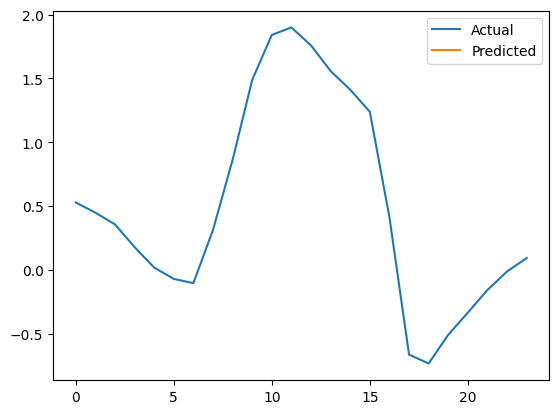

In [87]:
# p_train = vanilla_transformer_tester(trained_model, x, batch_size,use_y_tgt=use_y_tgt, train_y_tensor=y)
p_train = vanilla_transformer_tester(trained_model, x, batch_size)
# for b in range(batch_size):
#     plt.plot(y.reshape(-1,batch_size,1)[:,b], label='Actual')
#     plt.plot(p_train.cpu()[:,b], label='Predicted')
#     plt.legend()
#     plt.show()
    
plt.plot(y.reshape(-1)[(fore_days-1)*24:], label='Actual')
plt.plot(p_train.cpu().view(-1)[(fore_days-1)*24:], label='Predicted')
# plt.plot(p[:,1], label='Predicted')
plt.legend()
plt.show()

torch.Size([264, 5636])
torch.Size([264])
torch.Size([240, 5636])
torch.Size([240, 5636])
torch.Size([40, 1])


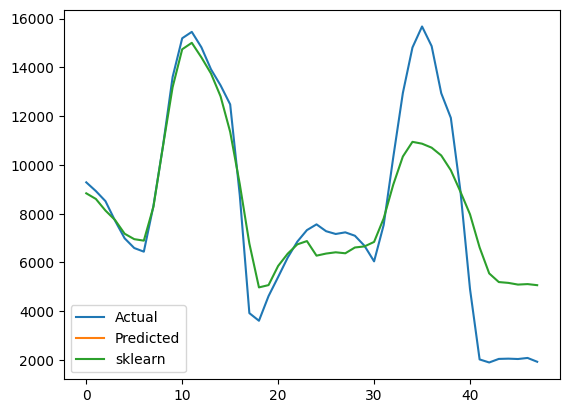

tensor([ 6115.6519,  7301.7607,  7133.3955,  6546.1392,  6666.6670,  7525.8213,
         8497.9580, 10117.0586, 12844.9600, 15716.0967, 17844.5234, 16230.4951,
        14782.6270, 14589.8213, 14973.6982, 17033.9688, 15526.1807, 13020.0527,
        11674.9355, 12157.4932, 12229.3555, 11898.4590, 11156.8457,  9988.7051,
         9285.9209,  8928.3438,  8514.5420,  7713.1895,  6989.5571,  6591.6914,
         6442.2246,  8318.6836, 10789.1816, 13606.5605, 15195.8994, 15457.7500,
        14825.0557, 13921.6445, 13263.0674, 12482.7568,  8761.9258,  3920.9270,
         3608.8372,  4620.7153,  5404.1743,  6201.7280,  6854.4341,  7326.6084,
         7562.1948,  7281.1924,  7167.8071,  7234.8389,  7095.7363,  6683.6792,
         6044.3018,  7537.0532, 10316.5791, 12950.6064, 14815.7041, 15679.1445,
        14872.3594, 12941.3916, 11930.6777,  8933.4561,  4904.8047,  2022.2686,
         1897.0435,  2043.3478,  2053.8005,  2039.1650,  2082.8679,  1926.5878])
[]


In [85]:
# his_days = fore_days - 1
print(x_hat.shape)
print(y_hat.shape)
his_days = fore_days - 2
test_st_days = 1
x_hat_s = x_hat[(test_st_days * 24):]
y_hat_s = y_hat[(test_st_days * 24):]
print(x_hat_s.shape)
print(x_hat_s.shape)


rfr = SVR()
rfr.fit(x.reshape(-1,input_size).numpy(),y.reshape(-1).numpy())
rfr_p = rfr.predict(x_hat_s.reshape(-1, input_size).numpy())

# p_test = vanilla_transformer_tester(trained_model, x_hat_s, batch_size)
# p_test = vanilla_transformer_tester(trained_model, x_hat_s, batch_size, True, y)
p_test = vanilla_transformer_tester(trained_model, x_hat_s, batch_size)
print(p_test.shape)
# for b in range(batch_size):
#     p_b = p_test.cpu()[:,b]
#     re_normed_p_b = y_norml_method.invert(p_b, yp)
#     plt.plot(y_hat.reshape(-1,batch_size,1)[:,b], label='Actual')
#     plt.plot(re_normed_p_b, label='Predicted')
#     plt.legend()
#     plt.show()
  

re_normed_p_test =  y_norml_method.invert(p_test.cpu().view(-1), yp)[his_days*24:]
re_normed_sklearn = y_norml_method.invert(rfr_p, yp)[his_days*24:]
plt.plot(y_hat_s.reshape(-1)[his_days*24:], label='Actual')
plt.plot(re_normed_p_test, label='Predicted')
plt.plot(re_normed_sklearn, label='sklearn')
# plt.plot(p[:,1], label='Predicted')
plt.legend()
plt.show()

print(y_hat.reshape(-1)[his_days*24:])
print(re_normed_p_test)